In [15]:
import pandas, keras
import numpy as np
from sklearn.metrics import roc_auc_score
from IPython.display import FileLink, FileLinks

In [16]:
# 1 image has 16x16 pixels = 256 pixels
pixels = ["pixel_{0}".format(i) for i in range(36)]

def to_image(df):
    return  np.expand_dims(np.expand_dims(df[pixels], axis=-1).reshape(-1,6,6), axis=-1)


store_train = pandas.HDFStore("pixelTrain.h5")

df_train = store_train.select("df",stop=-1)
df_train = df_train[(df_train["GenDeltaR"]<0.1) & (df_train["nUniqueSimTracksInSharedHit"]>-1)]


store_test = pandas.HDFStore("pixelTrain30k.h5")

df_test = store_test.select("df",stop=-1)
df_test = df_test[(df_test["GenDeltaR"]<0.1) & (df_test["nUniqueSimTracksInSharedHit"]>-1)]#print(df_test)
images_test = to_image(df_test)


# Make all test, train data merged hit
df_test = df_test[(df_test["isSharedHit"]>0)]
df_train = df_train[(df_train["isSharedHit"]>0)]

In [17]:
# Check that all are merged hits i.e. isSharedHit=1
print df_test['isSharedHit'].head()
print df_train['isSharedHit'].head()

25    1
30    1
39    1
69    1
92    1
Name: isSharedHit, dtype: int32
4     1
9     1
10    1
12    1
21    1
Name: isSharedHit, dtype: int32


In [18]:
print df_test.shape
print df_train.shape

# Remove overlap between train and test data
df_combined = pandas.concat([df_test, df_train]).drop_duplicates(keep=False)
df_combined.shape


# New combined files
df_train=df_combined.sample(frac=0.6)
df_test=df_combined.drop(df_train.index)

# Make all test, train data merged hit
df_test = df_test[(df_test["isSharedHit"]>0)]
df_train = df_train[(df_train["isSharedHit"]>0)]

df_train = df_train[(df_train["GenDeltaR"]<0.1) & (df_train["nUniqueSimTracksInSharedHit"]>-1)]


images_train = to_image(df_train)
images_test = to_image(df_test)

(58, 42)
(267, 42)


In [19]:
print df_test.shape
print df_train.shape

(114, 42)
(173, 42)


In [20]:
# Adding isMergedHit column 

merged_hit = df_train["nUniqueSimTracksInSharedHit"]>1
merged_int = merged_hit.astype(int)
df_train.insert(0, "isMergedHit", merged_int, True)

#df_train.head()

merged_hit_test = df_test["nUniqueSimTracksInSharedHit"]>1
merged_int_test = merged_hit_test.astype(int)
df_test.insert(0, "isMergedHit", merged_int_test, True)

df_test.head()

,isMergedHit,isSharedHit,trackPt,trackEta,trackPhi,nUniqueSimTracksInSharedHit,GenDeltaR,pixel_0,pixel_1,pixel_2,...,pixel_26,pixel_27,pixel_28,pixel_29,pixel_30,pixel_31,pixel_32,pixel_33,pixel_34,pixel_35
25,0,1,1.929511,-2.201498,1.929511,1.0,0.014203,0.0,0.000000,0.000000,...,0.074612,0.040008,0.000000,0.0,0.0,0.0,0.107974,0.000000,0.000000,0.0
30,1,1,5.074821,-1.558144,5.074821,2.0,0.005103,0.0,0.084432,0.000000,...,0.040934,0.000000,0.151445,0.0,0.0,0.0,0.000000,0.000000,0.245498,0.0
92,0,1,1.927646,-2.203123,1.927646,1.0,0.016287,0.0,0.000000,0.000000,...,0.000000,0.403630,0.056244,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
228,0,1,13.573482,-0.220184,13.573482,1.0,0.003009,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
244,1,1,1.325152,-2.043820,1.325152,2.0,0.042191,0.0,0.000000,0.056693,...,0.056526,0.150119,0.000000,0.0,0.0,0.0,0.072208,0.098132,0.000000,0.0


In [21]:
# Check for overlap
pandas.merge(df_train, df_test, on=[x for x in df_train.columns], how='inner')

,isMergedHit,isSharedHit,trackPt,trackEta,trackPhi,nUniqueSimTracksInSharedHit,GenDeltaR,pixel_0,pixel_1,pixel_2,...,pixel_26,pixel_27,pixel_28,pixel_29,pixel_30,pixel_31,pixel_32,pixel_33,pixel_34,pixel_35


In [22]:
from sklearn.model_selection import train_test_split
X = df_train.iloc[:,np.r_[1:4, 6:43]]
Y = df_train['isMergedHit']
#train_SharedHit = images_train['isMergedHit']

x_final_test = df_test.iloc[:,np.r_[1:4, 6:43]]
y_final_test = df_test['isMergedHit']

# Splitting train data into training and validation datasets
x_train, x_test, y_train_v, y_test_v = train_test_split(X, Y, test_size = 0.4, random_state = 2)

print Y.shape
print X.shape

(173,)
(173, 40)


In [23]:
# Random Forest
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
# Defining Model

clf = RandomForestClassifier()

clf.fit(x_train, y_train_v)

# Predictions on training 
y_pred_train = clf.predict(x_train)

# Predictions for test
y_pred_test = clf.predict(x_test)

# Training metrics
print("Training metrics:")
print(sklearn.metrics.classification_report(y_train_v, y_pred_train))

# Test data metrics
print("Validation test data metrics:")
print(sklearn.metrics.classification_report(y_test_v, y_pred_test))
print accuracy_score(y_test_v, y_pred_test)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

Training metrics:
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        54
          1       1.00      1.00      1.00        49

avg / total       1.00      1.00      1.00       103

Validation test data metrics:
             precision    recall  f1-score   support

          0       0.81      0.96      0.88        27
          1       0.97      0.86      0.91        43

avg / total       0.91      0.90      0.90        70

0.9


In [24]:
# Predictions on test set
y_pred_final_test = clf.predict(x_final_test)

# Final test data metrics
print("Test data metrics:")
print(sklearn.metrics.classification_report(y_final_test, y_pred_final_test))

# Evaluating the model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print 'Accuracy Score'
print accuracy_score(y_final_test, y_pred_final_test)

Test data metrics:
             precision    recall  f1-score   support

          0       0.71      0.89      0.79        44
          1       0.92      0.77      0.84        70

avg / total       0.84      0.82      0.82       114

Accuracy Score
0.8157894736842105


Confusion Matrix


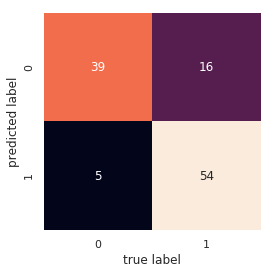

In [25]:
# Not very important, confusion matrix plot
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

print 'Confusion Matrix'
mat = confusion_matrix(y_final_test, y_pred_final_test) 
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

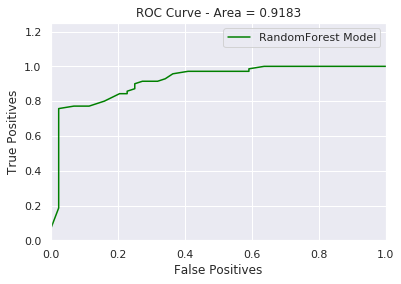

In [26]:
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.datasets import make_classification
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Getting rid of warning for .as_matrix
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# ROC Curve for RandomForest
probs = clf.predict_proba(x_final_test)[:,1]

merged_array = df_test.as_matrix(columns=df_test.columns[:1])

fpr, tpr, thresholds = roc_curve(merged_array, probs)
auc = metrics.auc(fpr,tpr)
auc = round(auc, 4)
plt.xlim(0, 1.0)
plt.ylim(0, 1.25)
plt.plot(fpr,tpr, color='green', label='RandomForest Model')
plt.title("ROC Curve - Area = "+str(auc))
plt.xlabel('False Positives')
plt.ylabel('True Positives')
plt.legend()
plt.show()

shared hits with at least 2 sim tracks:
0.531791907514


Text(0.5,1,'nUniqueSimTracksInSharedHit')

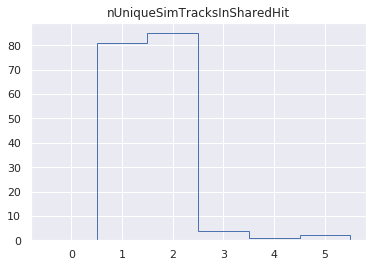

In [27]:
print "shared hits with at least 2 sim tracks:"
print float(sum(df_train["nUniqueSimTracksInSharedHit"]>1))/len(df_train["nUniqueSimTracksInSharedHit"])
plt.hist(df_train["nUniqueSimTracksInSharedHit"],histtype="step",bins=6,range=(-0.5,5.5))
plt.title("nUniqueSimTracksInSharedHit")

0.531791907514


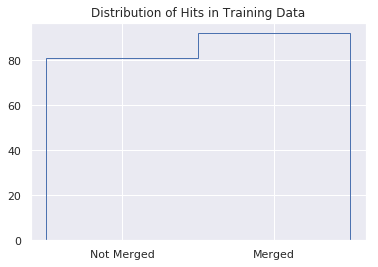

In [28]:
print float(sum(df_train["nUniqueSimTracksInSharedHit"]>1))/len(df_train["nUniqueSimTracksInSharedHit"])
plt.hist(df_train["nUniqueSimTracksInSharedHit"]>1,histtype="step",bins=2,range=(-0.5,1.5))
plt.title("Distribution of Hits in Training Data")
plt.xticks([0,1],("Not Merged","Merged"))
plt.savefig("merged_dist.png")
plt.savefig("merged_dist.pdf")